In [1]:
# Copyright (C) 2020 Luceda Photonics
# Modified by Ongun Arisev (ongunarisev@gmail.com)
from siepic import all as pdk
from ipkiss3 import all as i3
import numpy as np
import pylab as plt
from mzi_pcell_bdc import MZI_BDC

In [2]:
# Parameters for the MZI sweep
control_points = [(70.0, 240.0), (100.0, 240.0), (150.0, 240.0)]
bend_radius = 5.0
x0 = 40.0
y0 = 20.0
spacing_x = 180.0

In [3]:
insts = dict()
specs = []

In [4]:
# Create the floorplan (This is the design area allocated to us by SiEPIC)
floorplan = pdk.FloorPlan(name="FLOORPLAN", size=(605.0, 410.0))

# Add the floorplan to the instances dict and place it at (0.0, 0.0)
insts["floorplan"] = floorplan
specs.append(i3.Place("floorplan", (0.0, 0.0)))

In [5]:
# Create the MZI sweep
for ind, cp in enumerate(control_points):
    mzi = MZI_BDC(
        name="MZI{}".format(ind+1),
        control_point=cp,
        bend_radius=bend_radius,
    )

    # Calculate the actual delay length and print the results
    right_arm_length = mzi.get_connector_instances()[1].reference.trace_length()
    left_arm_length = mzi.get_connector_instances()[0].reference.trace_length()
    delay_length = right_arm_length - left_arm_length

    print(
        mzi.name,
        "Delay length = {} um".format(delay_length),
        "Control point = {}".format(cp),
    )

    mzi_cell_name = "mzi{}".format(ind)
    insts[mzi_cell_name] = mzi
    specs.append(i3.Place(mzi_cell_name, (x0, y0)))

    x0 += spacing_x


MZI1 Delay length = 76.30776389722621 um Control point = (70.0, 240.0)
MZI2 Delay length = 136.30776389722615 um Control point = (100.0, 240.0)
MZI3 Delay length = 236.30776389722615 um Control point = (150.0, 240.0)


In [6]:
# Create the final design with i3.Circuit
cell = i3.Circuit(
    name="EBeam_Vesnog_varying_parameters",
    insts=insts,
    specs=specs,
)


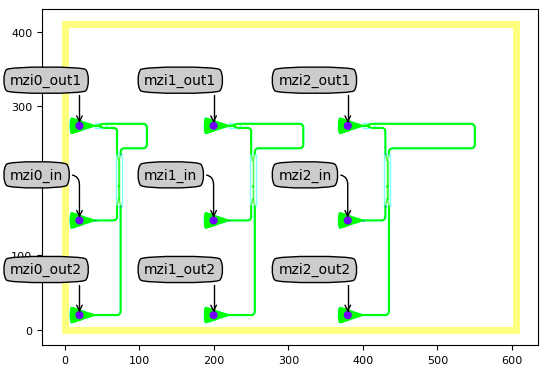

C:\Users\ongun\PycharmProjects\ipkiss_training\EBeam_Vesnog_varying_parameters.gds

In [7]:
# Layout
cell_lv = cell.Layout()
cell_lv.visualize(annotate=True)
cell_lv.write_gdsii("EBeam_Vesnog_varying_parameters.gds")


In [8]:
# Circuit model
cell_cm = cell.CircuitModel()
wavelengths = np.linspace(1.50, 1.58, 8001)
S_total = cell_cm.get_smatrix(wavelengths=wavelengths)

# Cannot go beyond 1.58 micron due to limitations of the model of the Y-splitter
# def calculate_smatrix(parameters, env, S):
#     if (env.wavelength < 1.5) or (env.wavelength > 1.58):
#         raise Exception(
#             "The wavelength is beyond the range of wavelength data points used for the Y-splitter model"
#         )


C:\ProgramData\Anaconda3\envs\ipkiss3\lib\site-packages\ipkiss3\simulation\engines\caphe_circuit_sim\caphenodegenerator.py:376: UserWarning: The following child nodes are not connected and will be removed:
floorplan
  warn(msg)


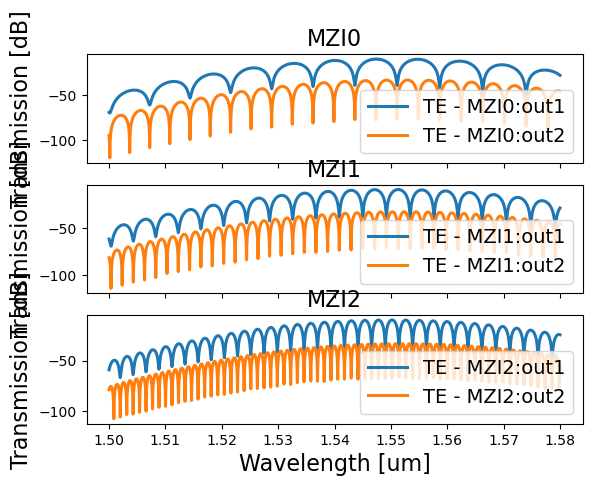

Done


In [9]:
# Plotting
fig, axs = plt.subplots(3, sharex="all")

for ind, cp in enumerate(control_points):
    tr_out1 = i3.signal_power_dB(S_total["mzi{}_out1:0".format(ind), "mzi{}_in:0".format(ind)])
    tr_out2 = i3.signal_power_dB(S_total["mzi{}_out2:0".format(ind), "mzi{}_in:0".format(ind)])

    axs[ind].plot(wavelengths, tr_out1, "-", linewidth=2.2, label="TE - MZI{}:out1".format(ind))
    axs[ind].plot(wavelengths, tr_out2, "-", linewidth=2.2, label="TE - MZI{}:out2".format(ind))

    axs[ind].set_ylabel("Transmission [dB]", fontsize=16)
    axs[ind].set_title("MZI{}".format(ind), fontsize=16)
    axs[ind].legend(fontsize=14, loc=4)

axs[2].set_xlabel("Wavelength [um]", fontsize=16)
plt.show()

print("Done")
